# Analysis Phase

This notebook analyzes a dataset of customer complaints to uncover trends, common issues, and sentiment analysis. The analysis leverages data visualization and text processing to extract meaningful insights from complaint data.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import re
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import warnings
from langdetect import detect



warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("complaints.csv")

## Dataset Description
The dataset consists of customer complaints submitted to financial institutions. It includes various fields such as:

- **Unnamed: 0**: Index column.
- **product_5**: General category of the financial product related to the complaint.
- **narrative**: The detailed description of the complaint provided by the consumer.
- **Product**: The specific type of product/service involved.
- **Date received**: The date the complaint was registered.
- **Sub-product**: A more granular classification of the product.
- **Issue**: The main problem described in the complaint.
- **Sub-issue**: A more detailed classification of the issue.
- **Company**: The financial institution or entity that received the complaint.
- **State**: The state where the complaint originated.
- **Timely response?**: Indicates whether the company responded within an appropriate timeframe.

In [9]:
df.head(10)

,Unnamed: 0,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?
0,234,Credit Reporting,Dear Possible Financial Inc you guyss aree rep...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Incorrect information on your report,Account information incorrect,Possible Financial Inc,MI,Yes
1,240,Debt Collection,"XXXX XXXX XXXX ( debt collector ), sent my boy...",Debt collection,2024-07-27,I do not know,Threatened to contact someone or share informa...,Talked to a third-party about your debt,BlueChip Financial,TX,Yes
2,257,Credit Reporting,I been receiving alerts my information was fou...,Credit reporting or other personal consumer re...,2024-07-23,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,FC HoldCo LLC,SC,Yes
3,271,Credit Reporting,Subject : Dispute of Inaccurate Information on...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,GA,Yes
4,276,Loans,They allowed me to use the account for about a...,"Payday loan, title loan, personal loan, or adv...",2024-07-26,Payday loan,Received a loan you didn't apply for,NaN,MoneyLion Inc.,PA,Yes
5,279,Credit Reporting,Do you believe your company owns the promissor...,Credit reporting or other personal consumer re...,2024-07-26,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,OH,Yes
6,302,Bank Accounts and Services,I used Wells Fargo Bank to make Payments for M...,"Money transfer, virtual currency, or money ser...",2024-07-30,"Money order, traveler's check or cashier's check",Lost or stolen money order,NaN,WELLS FARGO & COMPANY,NY,Yes
7,324,Loans,I had an installment loan under my name that w...,"Payday loan, title loan, personal loan, or adv...",2024-07-25,Installment loan,Charged fees or interest you didn't expect,NaN,REGIONS FINANCIAL CORPORATION,NJ,Yes
8,328,Debt Collection,Credit acceptance sent me court papers stating...,Debt collection,2024-07-24,Auto debt,Took or threatened to take negative or legal a...,Collected or attempted to collect exempt funds,CREDIT ACCEPTANCE CORPORATION,NY,Yes
9,338,Loans,XXXX Morgage company sent a payment to XXXX XX...,Mortgage,2024-07-24,Conventional home mortgage,Trouble during payment process,"Escrow, taxes, or insurance","SELECT PORTFOLIO SERVICING, INC.",OH,Yes


In [10]:
# 1. Check for missing values
def missing_values(df):
    missing = df.isnull().sum()
    print("Missing values by column:")
    print(missing[missing > 0])

# 2. Basic statistics
def basic_statistics(df):
    print("\nDataFrame information:")
    print(df.info())
    print("\nDescription of numerical columns:")
    print(df.describe())
    print("\nCategory distribution:")
    print(df['Product'].value_counts())

# 3. Count unique values in categorical columns
def categorical_analysis(df, column):
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[column], order=df[column].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

# 4. Temporal analysis of complaints
def time_analysis(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    df['YearMonth'] = df[date_column].dt.to_period('M')
    plt.figure(figsize=(12, 6))
    df['YearMonth'].value_counts().sort_index().plot(kind='line', marker='o', color='b')
    plt.title(f'Number of complaints over time ({date_column})')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of complaints')
    plt.xticks(rotation=45)
    plt.show()

# 5. Distribution of text length
def text_length_distribution(df, column):
    df['text_length'] = df[column].dropna().apply(len)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['text_length'], bins=30, kde=True, color='purple')
    plt.title(f'Distribution of text length in {column}')
    plt.xlabel('Number of characters')
    plt.ylabel('Frequency')
    plt.show()

# 6. Generate WordCloud
def generate_wordcloud(df, column):
    text = ' '.join(df[column].dropna()).lower()
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Complaints')
    plt.show()

# 7. Detect languages in the text column
LANGUAGE_MAP = {
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "de": "German",
    "it": "Italian",
    "pt": "Portuguese",
    "nl": "Dutch",
    "ru": "Russian",
    "zh-cn": "Chinese (Simplified)",
    "zh-tw": "Chinese (Traditional)",
    "ar": "Arabic",
    "ja": "Japanese",
    "ko": "Korean",
    "vi": "Vietnamese",
    "ro": "Romanian",
    "so": "Somali",
    "ca": "Catalan",
    "af": "Afrikaans",
    "no": "Norwegian",
    "da": "Danish",
    "tl": "Tagalog",
    "cy": "Welsh",
    "unknown": "Unknown"
}

def detect_languages(df, column, sample_size=50000):
    """Detects languages in the given text column using a sample of data."""
    sample_texts = df[column].dropna().sample(min(sample_size, len(df)), random_state=42)
    detected_languages = [detect(text) for text in sample_texts]
    
    lang_counts = Counter(detected_languages)
    
    print("Detected languages and their frequencies:")
    for lang_code, count in lang_counts.items():
        lang_name = LANGUAGE_MAP.get(lang_code, lang_code) 
        print(f"{lang_name}: {count}")
    
    return Counter(detected_languages)


def plot_language_distribution(lang_counts):
    """Plots the distribution of detected languages."""
    lang_labels = [LANGUAGE_MAP.get(lang, lang) for lang in lang_counts.keys()]
    counts = list(lang_counts.values())
    
    # Bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts, y=lang_labels, palette="viridis")
    plt.xlabel("Frequency")
    plt.ylabel("Language")
    plt.title("Detected Language Distribution (Bar Plot)")
    plt.show()
    
    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=lang_labels, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("viridis", len(lang_labels)))
    plt.title("Detected Language Distribution (Pie Chart)")
    plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


## Check for Missing Values
The missing_values function identifies columns with missing values and displays the count per column.

In [11]:
missing_values(df)

Missing values by column:
Sub-product     52206
Sub-issue      230559
State            7344
dtype: int64


## Basic Statistics
The basic_statistics function provides an overview of the dataset, including:
- General DataFrame information.
- Descriptive statistics for numerical columns.
- Frequency distribution of different product categories.

In [12]:
basic_statistics(df)


DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023066 entries, 0 to 2023065
Data columns (total 11 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   product_5         object
 2   narrative         object
 3   Product           object
 4   Date received     object
 5   Sub-product       object
 6   Issue             object
 7   Sub-issue         object
 8   Company           object
 9   State             object
 10  Timely response?  object
dtypes: int64(1), object(10)
memory usage: 169.8+ MB
None

Description of numerical columns:
         Unnamed: 0
count  2.023066e+06
mean   2.942257e+06
std    1.548125e+06
min    2.340000e+02
25%    1.631738e+06
50%    2.878855e+06
75%    4.287420e+06
max    5.842318e+06

Category distribution:
Product
Credit reporting, credit repair services, or other personal consumer reports    807291
Credit reporting or other personal consumer reports                             3

## Categorical Analysis
The categorical_analysis function visualizes the distribution of values in a categorical column using a bar chart.
In this particular case we are analyzing the columns "Product" and "product_5".

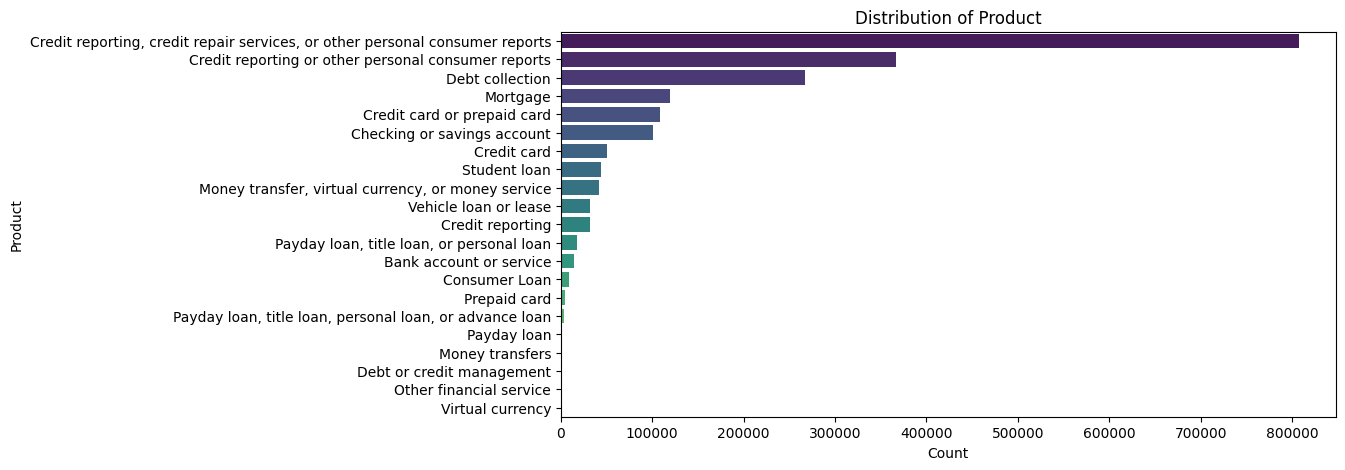

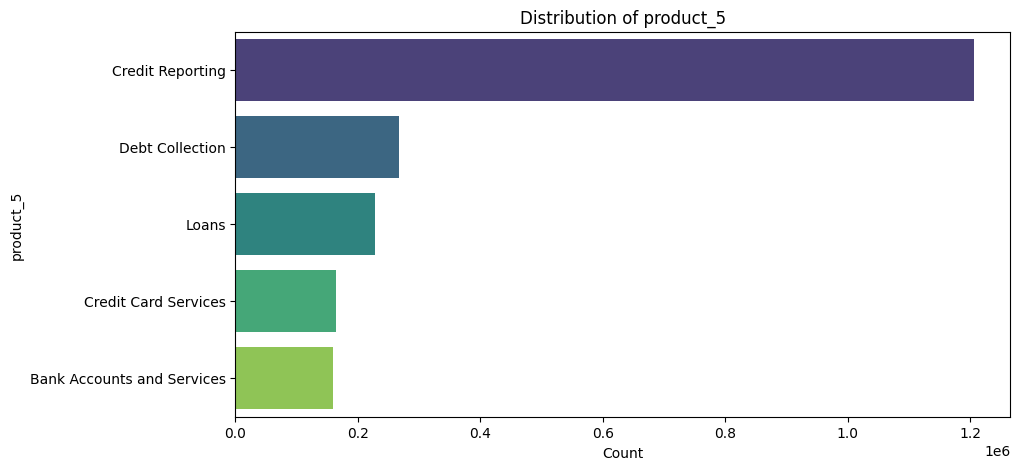

In [13]:
categorical_analysis(df, 'Product')
categorical_analysis(df, 'product_5')

## Temporal Analysis of Complaints
The time_analysis function converts the "Date received" column to a datetime format and visualizes the number of complaints over time using a line plot.

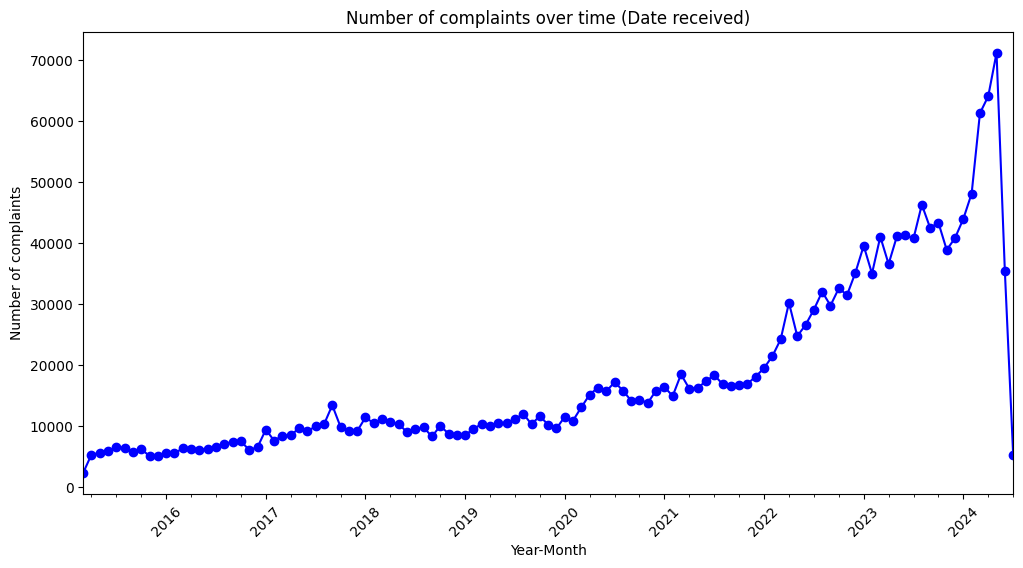

In [14]:
time_analysis(df, 'Date received')

## Distribution of Text Length
The text_length_distribution function calculates the character length of complaint narratives and issues and visualizes their distribution using a histogram.

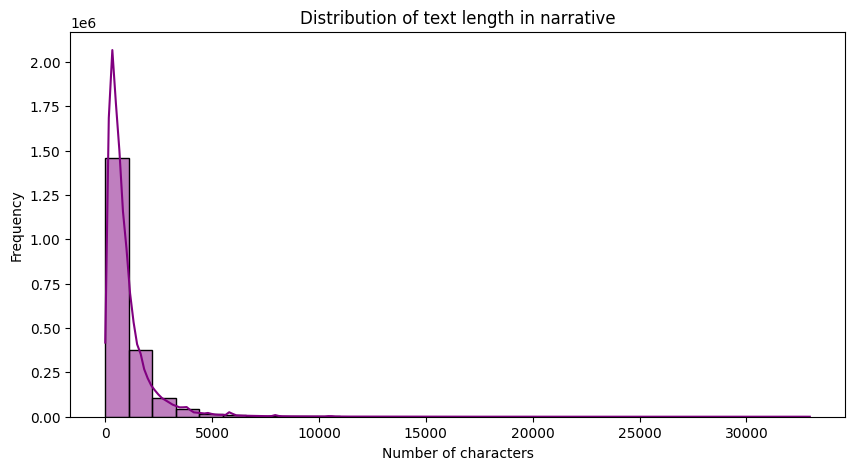

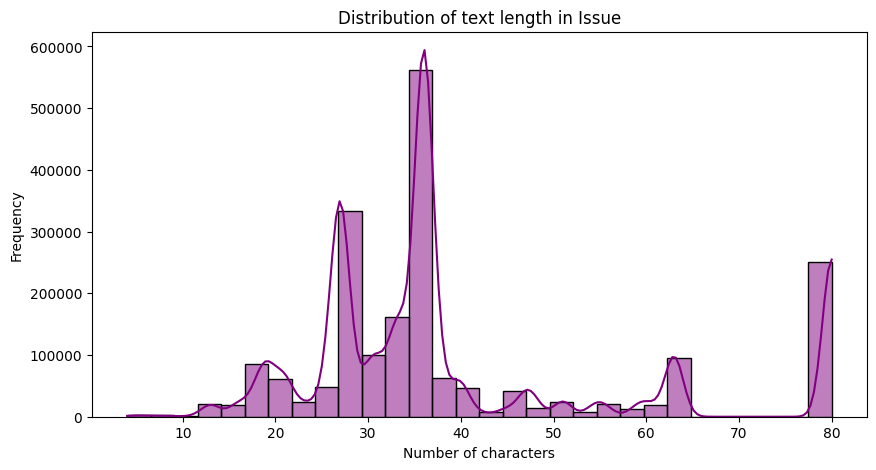

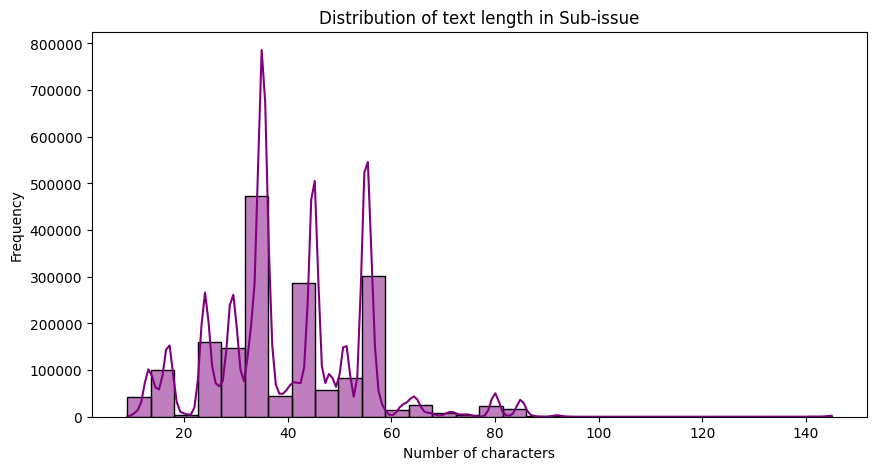

In [15]:
text_length_distribution(df, 'narrative')
text_length_distribution(df, 'Issue')
text_length_distribution(df, 'Sub-issue')

## Detect Languages in the Text Column
The detect_languages function detects the languages present in the complaint narratives using a sample of data. The detected languages are counted and displayed. With this we were able to understand if we had any language outliers.

In [16]:
lang_detects = detect_languages(df, 'narrative')

Detected languages and their frequencies:
English: 49004
Catalan: 800
Somali: 125
German: 7
Romanian: 21
Vietnamese: 15
French: 14
Afrikaans: 1
Norwegian: 2
Danish: 3
Spanish: 5
Italian: 1
Portuguese: 1
Tagalog: 1


## Plot Language Distribution
The plot_language_distribution function visualizes the detected language distribution using bar and pie charts. By visualizing these plots, we can see that english is the only important language in the dataset, all the others are outliers.

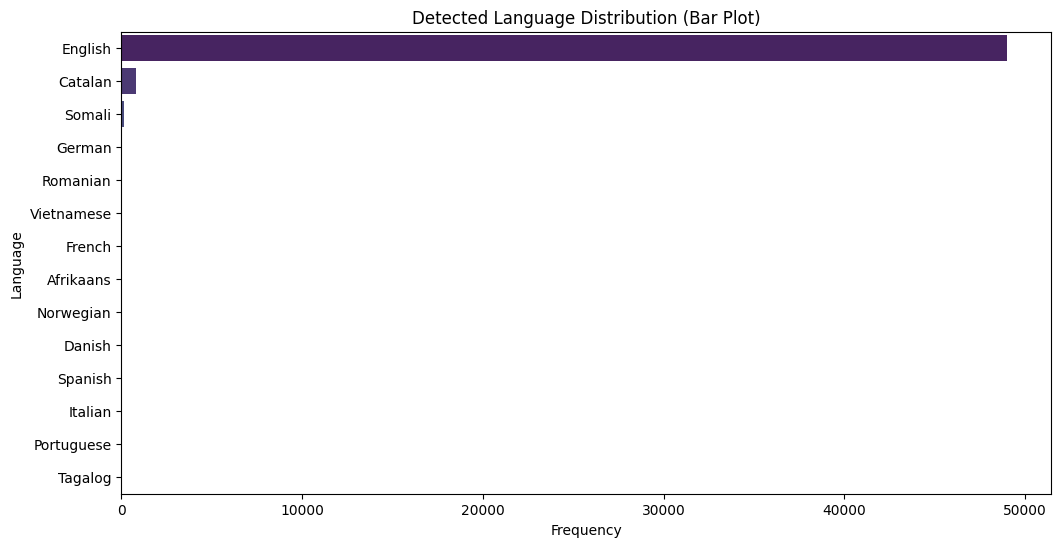

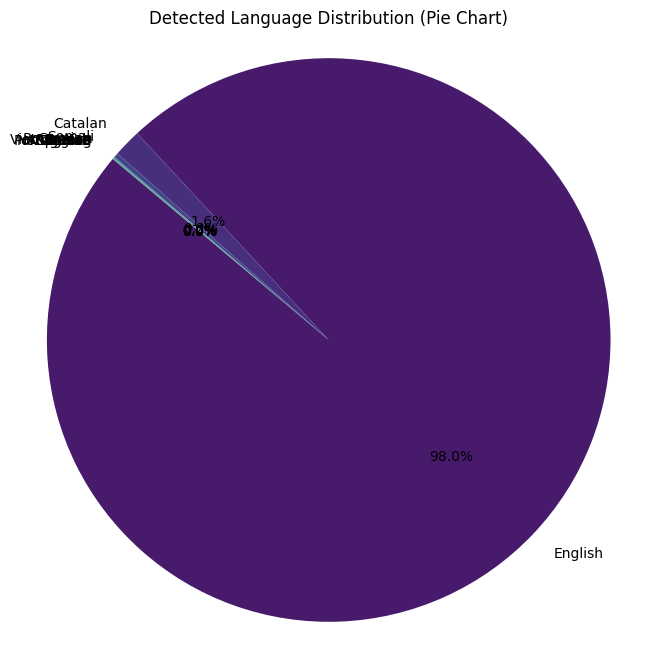

In [17]:
plot_language_distribution(lang_detects)

## Generate WordCloud
The generate_wordcloud function creates a word cloud to highlight frequently used words in customer complaints. Before generating the word cloud, the dataset is preprocessed by:
- Cleaning the text: The clean_text function removes sequences of 'x' characters that may represent redacted information.
- Sampling the dataset: To reduce memory usage, 7% of the dataset is randomly selected.
- Applying text cleaning: The clean_text function is applied to the sampled dataset's narrative column before generating the word cloud.

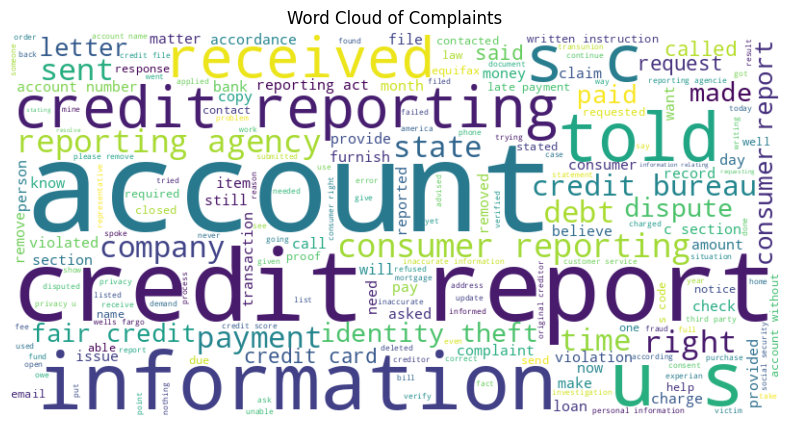

In [18]:
def clean_text(text):
    return re.sub(r'\b(x+\s*)+\b', '', text, flags=re.IGNORECASE).strip()

# Sample 7% of the data to reduce memory usage
sampled_df = df.sample(frac=0.07, random_state=1)

sampled_df['narrative'] = sampled_df['narrative'].apply(clean_text)

generate_wordcloud(sampled_df, 'narrative')